In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os, sys, glob
from PIL import Image
import io
import pickle
from collections import OrderedDict

In [52]:
dirstem = os.path.join(os.path.expanduser('~'), 'neuroailab', 'trials', 'nsf', 'wtow_*')
trials = sorted(glob.glob(dirstem), key=lambda t: int(t.split('_')[-1]))
trials = {int(trial.split('_')[-1]): trial for trial in trials}
trials

{0: '/Users/db/neuroailab/trials/nsf/wtow_0',
 1: '/Users/db/neuroailab/trials/nsf/wtow_1',
 2: '/Users/db/neuroailab/trials/nsf/wtow_2',
 3: '/Users/db/neuroailab/trials/nsf/wtow_3',
 4: '/Users/db/neuroailab/trials/nsf/wtow_4',
 5: '/Users/db/neuroailab/trials/nsf/wtow_5',
 6: '/Users/db/neuroailab/trials/nsf/wtow_6',
 7: '/Users/db/neuroailab/trials/nsf/wtow_7',
 8: '/Users/db/neuroailab/trials/nsf/wtow_8',
 10: '/Users/db/neuroailab/trials/nsf/wtow_10',
 11: '/Users/db/neuroailab/trials/nsf/wtow_11',
 12: '/Users/db/neuroailab/trials/nsf/wtow_12',
 13: '/Users/db/neuroailab/trials/nsf/wtow_13',
 14: '/Users/db/neuroailab/trials/nsf/wtow_14',
 15: '/Users/db/neuroailab/trials/nsf/wtow_15',
 16: '/Users/db/neuroailab/trials/nsf/wtow_16',
 17: '/Users/db/neuroailab/trials/nsf/wtow_17',
 18: '/Users/db/neuroailab/trials/nsf/wtow_18',
 19: '/Users/db/neuroailab/trials/nsf/wtow_19',
 20: '/Users/db/neuroailab/trials/nsf/wtow_20',
 21: '/Users/db/neuroailab/trials/nsf/wtow_21'}

0000.hdf5
top keys ['frames', 'static']
num frames: 302
frame data keys ['camera_matrices', 'collisions', 'did_fall', 'env_collisions', 'images', 'objects']
image keys ['_depth', '_flow', '_id', '_img', '_normals']


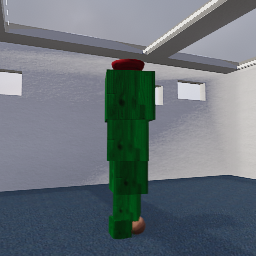

In [82]:
TDW_DIR = trials[21]
TNUM = 0
FILE = "%04d.hdf5" % TNUM
print(FILE)
view_frame = 10
f = h5py.File(os.path.join(TDW_DIR, FILE))

# print the data structure
print("top keys", [k for k in f.keys()])
frames = f['frames']
n_frames = len([k for k in frames.keys()])
print("num frames: {}".format(n_frames))
view_frame = np.minimum(view_frame, n_frames - 1)
frame = frames["%04d" % (view_frame)]
print("frame data keys", [k for k in frame.keys()])
img = frame['images']
print("image keys", [k for k in img.keys()])
_img = Image.open(io.BytesIO(img["_img"][:]))
_img

<IPython.core.display.Javascript object>


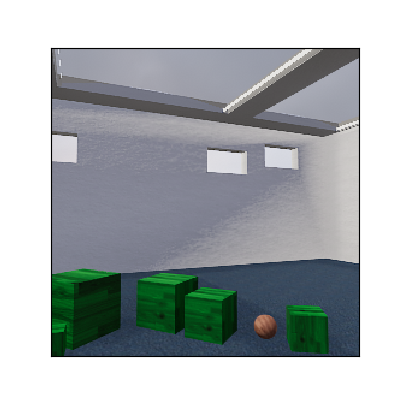

In [85]:
%matplotlib nbagg
SAVE = False

def get_frame(f, idx, imkey='_img', N=n_frames):
    fkeys = sorted([k for k in f['frames'].keys()])
    img = f['frames'][fkeys[idx % N]]['images']
    return np.array(Image.open(io.BytesIO(img[imkey][:]))), len(fkeys)

idx = 0

fig, axes = plt.subplots(figsize=(4,4))
fr0, n_frames = get_frame(f,idx)
im = plt.imshow(fr0, origin='upper')

def animate(*args):
    global idx
    
    fr, N = get_frame(f, idx, '_img')
    im.set_array(fr)
    idx += 1
    idx %= N
    
    return im,

def savegif(ani, directory=TDW_DIR, file=FILE):
    import os
    f = os.path.join(directory, file.split('.')[0]) + ".gif"
    writergif = animation.PillowWriter(fps=48)
    ani.save(f, writer=writergif)

ani = animation.FuncAnimation(fig, animate, interval=10, save_count=n_frames)
plt.xticks([])
plt.yticks([])
plt.show()

if SAVE:
    savegif(ani, TDW_DIR, FILE)

# Check Metadata

In [70]:
skeys = [k for k in f['static'].keys()]
print(skeys)

obj_ids = [oid for oid in f['static']['object_ids']]
print(len(obj_ids))

['bounciness', 'cap_type', 'color', 'dynamic_friction', 'mass', 'middle_type', 'object_ids', 'probe_mass', 'probe_type', 'push_force', 'push_position', 'scale_x', 'scale_y', 'scale_z', 'static_friction', 'target_rotation', 'target_type', 'use_cap']
7


In [71]:
key = 'color'
meta = f['static'][key]
print(np.array(meta))

[[1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Frame Data

In [49]:
fs = [k for k in f['frames'].keys()]
print("dynamic keys")
print([k for k in f['frames'][fs[0]].keys()])
print("collision keys")
print([k for k in f['frames'][fs[0]]['collisions'].keys()])

def get_collisions(hf, idx, env_collisions=False):
    fkeys = [k for k in hf['frames'].keys()]
    return hf['frames'][fkeys[idx]]['collisions' if not env_collisions else 'env_collisions']

def find_collisions_frames(hf, cdata='contacts', env_collisions=False):
    n_frames = len([k for k in hf['frames'].keys()])
    collisions = []
    for n in range(n_frames):
        contacts = get_collisions(hf, n, env_collisions)[cdata]
        collisions.append(bool(len(contacts)))
    return np.where(collisions)[0]

def did_fall(hf, idx=-1):
    fkeys = [k for k in hf['frames'].keys()]
    n_frames = len(fkeys)
    if n_frames > 5 and (idx % n_frames > 5):
        return np.array(hf['frames'][fkeys[idx]]["did_fall"])
    else:
        return None

dynamic keys
['camera_matrices', 'collisions', 'env_collisions', 'images', 'objects']
collision keys
['contacts', 'object_ids', 'relative_velocities', 'states']


In [59]:
find_collisions_frames(f, 'contacts', False)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [58]:
did_fall(f)

array(True)

In [74]:
np.array(f['frames'][fs[-1]]['objects']['positions'])

array([[-6.1926413e-01,  1.7541902e-01,  5.2562660e-01],
       [ 1.6113386e+00, -4.3362379e-06, -7.8561129e-03],
       [-7.9241860e-01,  2.9951334e-06,  7.9427350e-01],
       [-1.7090341e-01,  2.2500007e-01,  3.0034947e-01],
       [ 1.4894111e-01,  2.7500069e-01, -1.9382744e-01],
       [ 1.1593900e+00,  3.2500476e-01, -2.4631473e-01],
       [ 3.1602585e+00,  3.0186170e-01, -2.9471693e+00]], dtype=float32)